In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.graph_utils import JunctionTree
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data with Block Diagonal Structure

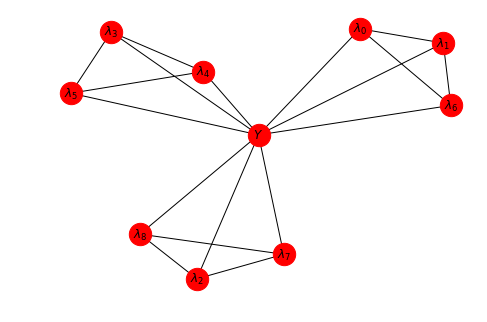

In [12]:
M = 9
N_CLUSTERS = 3
deps_graph = ClusterDependencies(M, N_CLUSTERS)
deps_graph.draw()

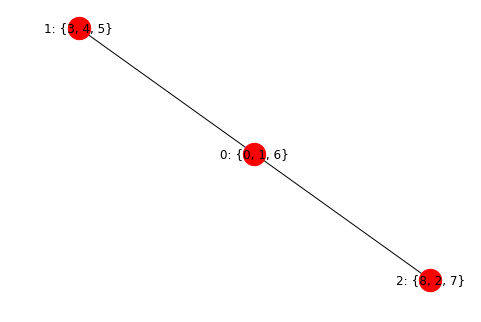

In [23]:
N = 1000 # Not used yet...
K = 2
HIGHER_ORDER_CLIQUES = True

data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
data.jt.draw()

#get true values for later comparison, label model
sigma_O = data.get_sigma_O()
class_balance = data.get_class_balance()

## Train LabelModel with True Dependencies
Note we use the class balance and Junction Tree from the data generator since these are observable/we assume are known

In [24]:
lm = LabelModel(k=2)

lm.train(
    sigma_O=sigma_O,
    junction_tree=data.jt,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000
)

Estimating Z...
[E:0]	Train Loss: 87.839
[E:1000]	Train Loss: 0.000
[E:2000]	Train Loss: 0.000
[E:3000]	Train Loss: 0.000
[E:4000]	Train Loss: 0.000
[E:5000]	Train Loss: 0.000
[E:6000]	Train Loss: 0.000
[E:7000]	Train Loss: 0.000
[E:8000]	Train Loss: 0.000
[E:9000]	Train Loss: 0.000
[E:9999]	Train Loss: 0.000
Finished Training
Estimating \mu...
[E:0]	Train Loss: 35.729
[E:1000]	Train Loss: 0.002
[E:2000]	Train Loss: 0.000
[E:3000]	Train Loss: 0.000
[E:4000]	Train Loss: 0.000
[E:5000]	Train Loss: 0.000
[E:6000]	Train Loss: 0.000
[E:7000]	Train Loss: 0.000
[E:8000]	Train Loss: 0.000
[E:9000]	Train Loss: 0.000
[E:9999]	Train Loss: 0.000
Finished Training


## Measure Error in True and Estimated $\mu$
Given the following:
$$\Sigma = \begin{bmatrix} \Sigma_O & \Sigma_{OH} \\ \Sigma_{HO} & \Sigma_H \end{bmatrix} $$

we want to focus on $$\Sigma_{OH} = \mathbb{E}[\lambda_i Y] - \mathbb{E}[\lambda_i]\mathbb{E}[Y]$$

where $\mathbb{E}[\lambda_i Y]$ are the LF accuracies, $\mathbb{E}[\lambda_i]$ are the observed label propensities, and $\mathbb{E}[Y]$ is the observed/known class balance.

In [47]:
sigma_O_inv = np.linalg.inv(sigma_O)
sigma_H = data.P_marginal({M:2})

mu = data.get_mu()
mu_x = sigma_H * np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
sigma_OH = mu - mu_x

SIGN_FLIP = 1 #For better than random assumption
mu_est = SIGN_FLIP * (lm.mu.detach().numpy() + mu_x.reshape([-1,1]))
np.hstack([mu_est, mu.reshape([-1, 1])])

print ("Error in mu: ", np.mean(np.abs(mu - mu_est.ravel())))

Error in mu:  0.01666269676434902
